Sample Code from Udemy GNN course

<div align="center">
<h1>Simple Graph Convolution classification for Cora data</h1>
    <img src="https://production-media.paperswithcode.com/datasets/Cora-0000000700-ce1c5ec7_LD7pZnT.jpg" width=500>
</div>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid # The citation network datasets “Cora”, “CiteSeer” and “PubMed”
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# Importing Data

In [3]:
path = "./input"  # Directory to download dataset
dataset = Planetoid(path, "Cora") # Download the dataset
data = dataset[0] # Tensor representation of the Cora-Planetoid data
print('Cora: ', data)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Processing...


Cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


# Node2Vec Model Construction

In [4]:
GCN_model = GCNConv(in_channels= data.num_features, # Number of features
                   out_channels= dataset.num_classes, # Dimension of embedding
                   )

print(" Shape of the original data: ", data.x.shape)
print(" Shape of GCN the embedding data: ", GCN_model(data.x,data.edge_index).shape)

 Shape of the original data:  torch.Size([2708, 1433])
 Shape of GCN the embedding data:  torch.Size([2708, 7])


# Embedding Visualization with T-SNE

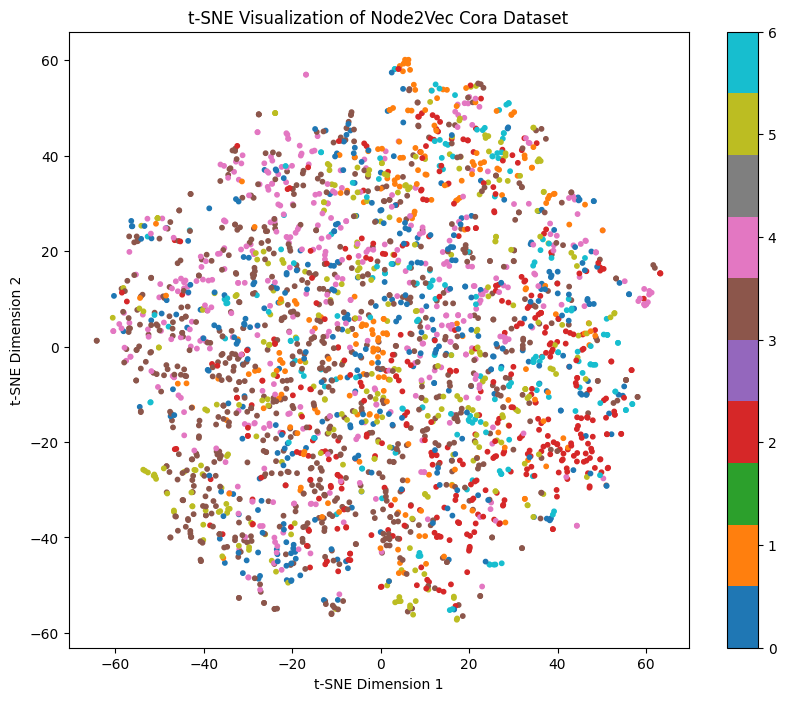

In [5]:
# Get node embeddings
embeddings = GCN_model(data.x,data.edge_index).detach().cpu().numpy()

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2)  # Change n_components to 3 for 3D visualization
embedding_tsne = tsne.fit_transform(embeddings)


# Plot the nodes
plt.figure(figsize=(10, 8))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=data.y, cmap='tab10', s=10)
plt.title('t-SNE Visualization of Node2Vec Cora Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

# GCN Classification Model

In [6]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """ GCNConv layers """
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GCN_model, data = GCN().to(device), data.to(device)
optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01, weight_decay=5e-4)

# What are the learning parameters:
for i, parameter in GCN_model.named_parameters():
    print(" Parameter {}".format(i))
    print("Shape: ",parameter.shape)

 Parameter conv1.bias
Shape:  torch.Size([16])
 Parameter conv1.lin.weight
Shape:  torch.Size([16, 1433])
 Parameter conv2.bias
Shape:  torch.Size([7])
 Parameter conv2.lin.weight
Shape:  torch.Size([7, 16])


# Train and Test functions

In [7]:
def GCNtrain():
    GCN_model.train() # Set the model.training to be True
    optimizer.zero_grad() # Reset the gradient
    predicted_y = GCN_model(data) # predicted y in log softmax prob
    true_y = data.y # True labels
    losses = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step() # Update the parameters such that is minimized the losses


def GCNtest():
    GCN_model.eval() # Set the model.training to be False
    logits = GCN_model(data) # Log prob of all data
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1] #Transforming log prob to actual labels
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# Application

GCN Epoch: 001, Train: 0.5929, Val: 0.3680, Test: 0.3830
GCN Epoch: 002, Train: 0.6929, Val: 0.4260, Test: 0.4370
GCN Epoch: 003, Train: 0.7571, Val: 0.4540, Test: 0.4530
GCN Epoch: 004, Train: 0.7571, Val: 0.4900, Test: 0.4810
GCN Epoch: 005, Train: 0.8143, Val: 0.5120, Test: 0.5270
GCN Epoch: 006, Train: 0.8786, Val: 0.5620, Test: 0.5710
GCN Epoch: 007, Train: 0.9286, Val: 0.6180, Test: 0.6150
GCN Epoch: 008, Train: 0.9571, Val: 0.6700, Test: 0.6580
GCN Epoch: 009, Train: 0.9714, Val: 0.6880, Test: 0.7020
GCN Epoch: 010, Train: 0.9714, Val: 0.7040, Test: 0.7230
GCN Epoch: 011, Train: 0.9786, Val: 0.7200, Test: 0.7400
GCN Epoch: 012, Train: 0.9929, Val: 0.7300, Test: 0.7520
GCN Epoch: 013, Train: 0.9929, Val: 0.7400, Test: 0.7580
GCN Epoch: 014, Train: 0.9929, Val: 0.7520, Test: 0.7640
GCN Epoch: 015, Train: 0.9929, Val: 0.7540, Test: 0.7700
GCN Epoch: 016, Train: 0.9929, Val: 0.7600, Test: 0.7750
GCN Epoch: 017, Train: 0.9929, Val: 0.7600, Test: 0.7750
GCN Epoch: 018, Train: 0.9929, 

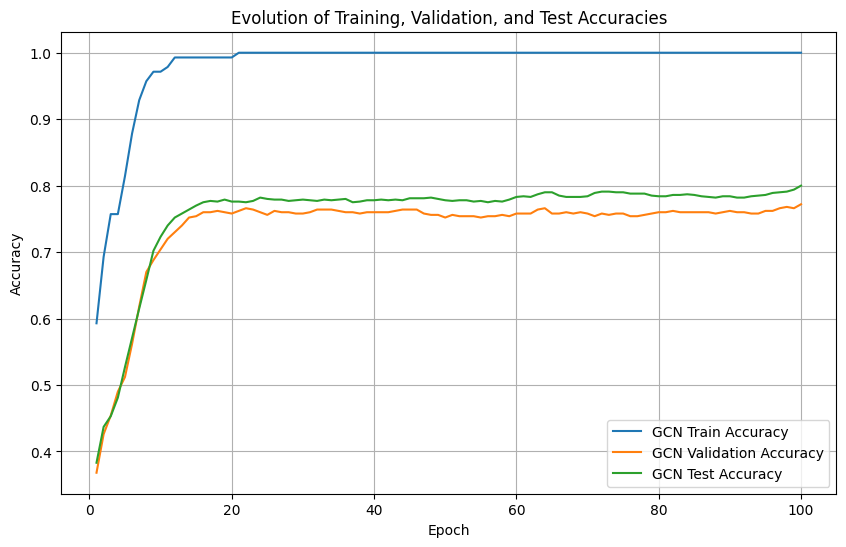

In [8]:

# Initialize lists to store accuracies

GCN_train_accs = []
GCN_val_accs = []
GCN_test_accs = []


GCN_best_val_acc = GCN_test_acc = 0

for epoch in range(1, 101):
    GCNtrain()

    GCN_train_acc, GCN_val_acc, GCN_tmp_test_acc = GCNtest()
    
        
    GCN_train_accs.append(GCN_train_acc)
    GCN_val_accs.append(GCN_val_acc)
    GCN_test_accs.append(GCN_tmp_test_acc)
    
    if GCN_val_acc > GCN_best_val_acc:
        GCN_best_val_acc = GCN_val_acc
        GCN_test_acc = GCN_tmp_test_acc
    
    GCNlog = 'GCN Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(GCNlog.format(epoch, GCN_train_acc, GCN_best_val_acc, GCN_test_acc))

# Plot the evolution of accuracies
plt.figure(figsize=(10, 6))
epochs = range(1, 101)

plt.plot(epochs, GCN_train_accs, label='GCN Train Accuracy')
plt.plot(epochs, GCN_val_accs, label='GCN Validation Accuracy')
plt.plot(epochs, GCN_test_accs, label='GCN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution of Training, Validation, and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()
